# Blueprint and overall stats

In [1]:
# Imports and data preparation
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from cardio.blueprints.blueprint_catalog import thecatalog
from cardio import skills, Card

plt.rcParams["figure.figsize"] = (9, 3)

cards = thecatalog._blueprints.instantiate()
attribute_names = [
    "name",
    "health",
    "power",
    "has_fire",
    "has_spirits",
    "costs_fire",
    "costs_spirits",
]
skill_types = skills.get_skilltypes(implemented_only=True)
skill_names = [s.__name__ for s in skill_types]

df = pd.DataFrame()
for attr in attribute_names:
    df[attr] = [getattr(c, attr) for c in cards]
df["human_potency"] = [c.potency("human") for c in cards]
df["computer_potency"] = [c.potency("computer") for c in cards]
df["skills"] = [c.skills.count() for c in cards]
for st, sn in zip(skill_types, skill_names):
    df[sn] = [st in c.skills for c in cards]

df.head(2)


,name,health,power,has_fire,has_spirits,costs_fire,costs_spirits,human_potency,computer_potency,skills,InstantDeath,Fertility,Soaring,Spines,Airdefense,Shield,Underdog,Packrat,LuckyStrike
0,Hamster,1,0,1,1,0,0,14,2,0,False,False,False,False,False,False,False,False,False
1,Koala,3,1,1,1,1,0,9,8,0,False,False,False,False,False,False,False,False,False


## General stats

### Total number of blueprints

In [2]:
len(df)

1689

### Skills by potency

In [3]:
sorted_skills = sorted(
    skills.get_skilltypes(implemented_only=True),
    key=lambda s: s.potency,
    reverse=True,
)
for s in sorted_skills:
    txt = f"{s.potency:3} {s.name} {s.symbol}"
    print(f"{txt:30} {s.forwhom if s.forwhom != skills.ForWhom.BOTH else ''}")


  9 Fertility 🐭                ForWhom.HUMAN
  7 Instant Death 💀            
  7 Shield 🔰                   
  6 Packrat 🧺                  ForWhom.HUMAN
  4 Underdog 🐩                 
  3 Spines 🦔                   
  2 Soaring 🪁                  
  1 Air Defense 🚀              
  0 Lucky Strike 🍀             


### Skills by count (in %)

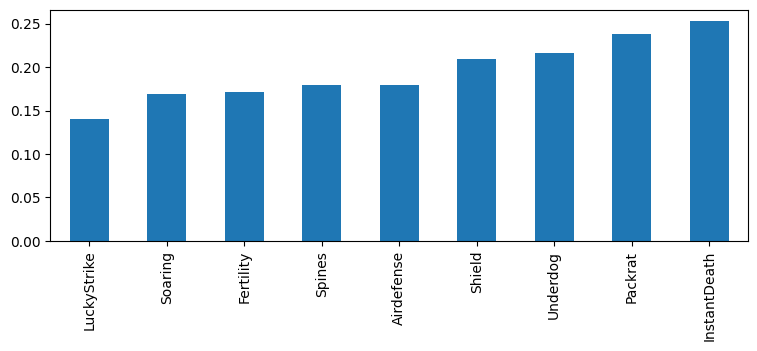

In [4]:
counts = df[skill_names].apply(pd.value_counts, normalize=True).loc[True].sort_values()
ax = counts.plot(kind="bar", rot=0)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Keep in mind that the probabilities will be tweaked for higher potencies, leading to a
higher chance of getting a skill with a higher potency. This is evident when we only
look at blueprints with a potency < 30:

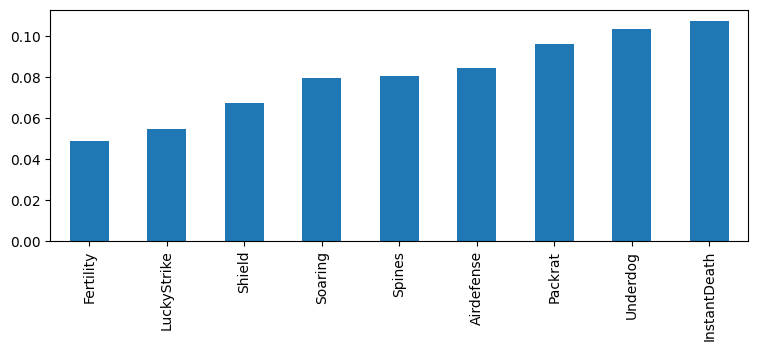

In [5]:
counts = df.query("human_potency < 30")[skill_names].apply(pd.value_counts, normalize=True).loc[True].sort_values()
ax = counts.plot(kind="bar", rot=0)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

### Number of skills per blueprint

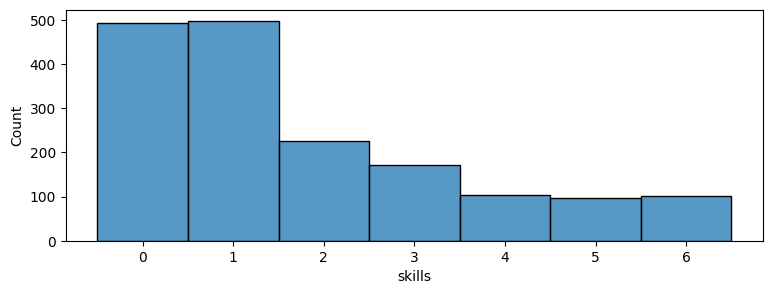

In [6]:
_ = sns.histplot(data=df, x="skills", discrete=True)

### Potency ranges

In [7]:
skills_by_potency = sorted(
    skills.get_skilltypes(implemented_only=True),
    key=lambda s: s.potency,
    reverse=True,
)
MINCARD = Card(
    name="Min",
    power=0,
    health=1,
    costs_fire=Card.MAX_ATTR,
    skills=[s for s in skills_by_potency[-Card.MAX_SKILLS :] if s.potency < 0],
    costs_spirits=0,  # 0, bc we can't have both types of costs in a card
    has_spirits=0,
    has_fire=0,
)
MAXCARD = Card(
    name="Max",
    power=Card.MAX_ATTR,
    health=Card.MAX_ATTR,
    costs_fire=0,
    skills=skills_by_potency[: Card.MAX_SKILLS],  # type: ignore
    costs_spirits=0,
    has_spirits=Card.MAX_ATTR,
    has_fire=Card.MAX_ATTR,
)
print()
print("Ranges:")
print(f"Human potency range: [{MINCARD.potency('human')}, {MAXCARD.potency('human')}]")
print(f"Computer potency range:  [{MINCARD.potency('computer')}, {MAXCARD.potency('computer')}]")

print("\nMin card:")
print(MINCARD)
print("\nMax card:")
print(MAXCARD)



Ranges:
Human potency range: [-8, 106]
Computer potency range:  [2, 61]

Min card:
Min  0p 1h
costs: 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥 has: - pot: -8/2

Max card:
Max 🐭💀🔰🧺🐩🦔 10p 10h
costs: - has: 🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥👻👻👻👻👻👻👻👻👻👻 pot: 106/61


### Health/power histo

Note that health of 0 is not allowed.

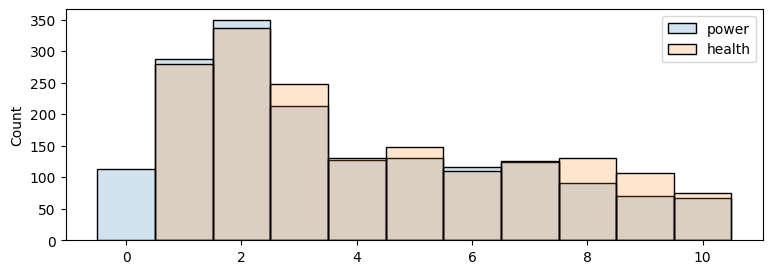

In [8]:
sns.histplot(data=df, x="power", discrete=True, alpha=0.2, label="power")
sns.histplot(data=df, x="health", discrete=True, alpha=0.2, label="health")
plt.gca().set_xlabel("")
_ = plt.legend()

### has_* histo

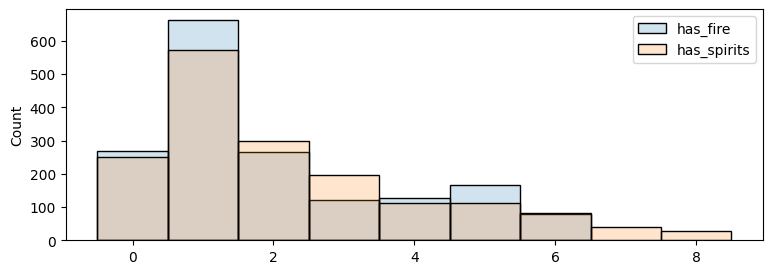

In [9]:
sns.histplot(data=df, x="has_fire", discrete=True, alpha=0.2, label="has_fire")
sns.histplot(data=df, x="has_spirits", discrete=True, alpha=0.2, label="has_spirits")
plt.gca().set_xlabel("")
_ = plt.legend()


### costs_* histo

Note that costs is squewed heavily towards fire, hence the large number of costs_spirits
== 0 and many more blueprints with costs_fire > 0.

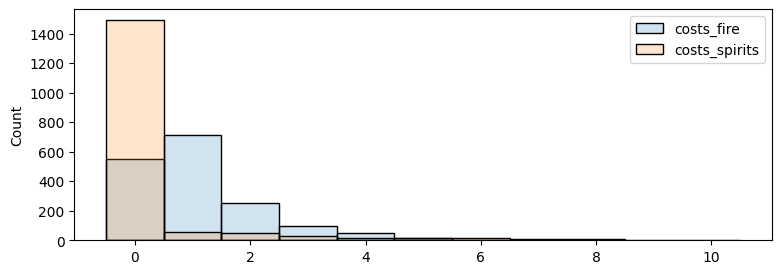

In [10]:
sns.histplot(data=df, x="costs_fire", discrete=True, alpha=0.2, label="costs_fire")
sns.histplot(data=df, x="costs_spirits", discrete=True, alpha=0.2, label="costs_spirits")
plt.gca().set_xlabel("")
_ = plt.legend()

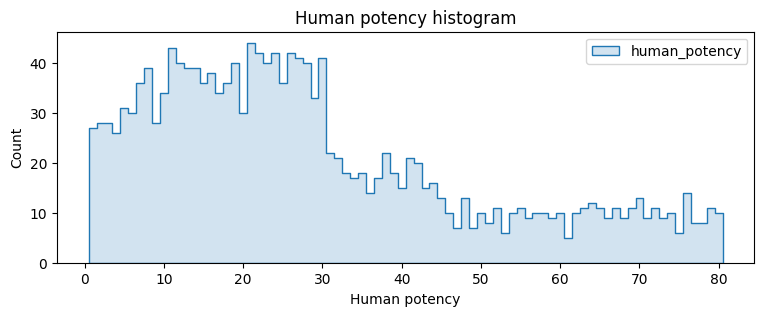

In [11]:
tf = df[(df["costs_fire"] == 0) & (df["costs_spirits"] == 0)]
sns.histplot(data=df, x="human_potency", discrete=True, element="step", alpha=0.2, label="human_potency")
plt.xlabel("Human potency")
plt.ylabel("Count")
plt.title("Human potency histogram")
_ = plt.legend()


## Potency histo

Computer potency biased towards even numbers because it is mainly driven by health and
power which are taken x2; odd numbers only possible via certain skills.

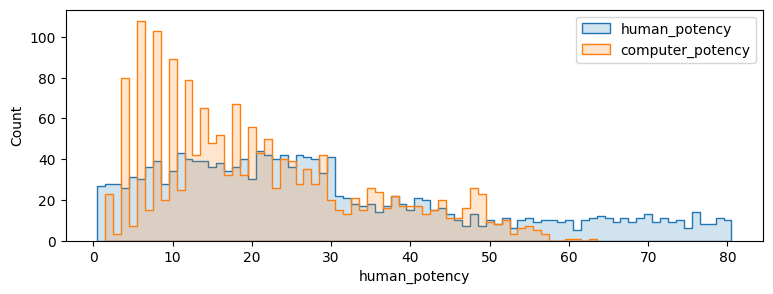

In [12]:
sns.histplot(data=df, x="human_potency", discrete=True, element="step", alpha=0.2, label="human_potency")
sns.histplot(data=df, x="computer_potency", discrete=True, element="step", alpha=0.2, label="computer_potency")
_ = plt.legend()

## Attributes vs potency

Note that it might seem counter-intuitive that costs go down with rising potency. But
keep in mind that potency is a measure of the overall value of a card/blueprint to a
player (human, in this case).

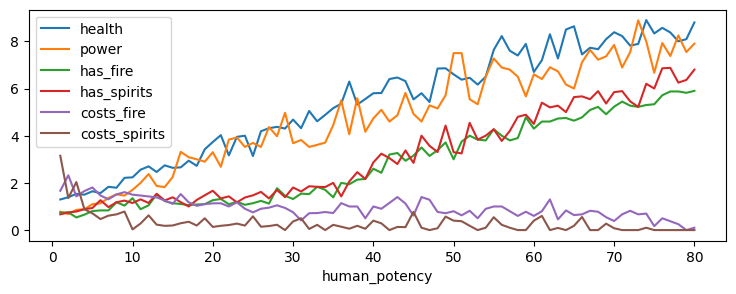

In [13]:
sns.lineplot(data=df, x="human_potency", y="health", errorbar=None, label="health")
sns.lineplot(data=df, x="human_potency", y="power", errorbar=None, label="power")
sns.lineplot(data=df, x="human_potency", y="has_fire", errorbar=None, label="has_fire")
sns.lineplot(data=df, x="human_potency", y="has_spirits", errorbar=None, label="has_spirits")
sns.lineplot(data=df, x="human_potency", y="costs_fire", errorbar=None, label="costs_fire")
sns.lineplot(data=df, x="human_potency", y="costs_spirits", errorbar=None, label="costs_spirits")
plt.gca().set_ylabel('')
_ = plt.legend()

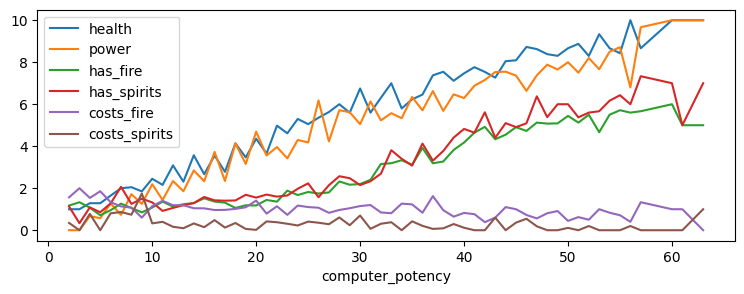

In [14]:
sns.lineplot(data=df, x="computer_potency", y="health", errorbar=None, label="health")
sns.lineplot(data=df, x="computer_potency", y="power", errorbar=None, label="power")
sns.lineplot(data=df, x="computer_potency", y="has_fire", errorbar=None, label="has_fire")
sns.lineplot(data=df, x="computer_potency", y="has_spirits", errorbar=None, label="has_spirits")
sns.lineplot(data=df, x="computer_potency", y="costs_fire", errorbar=None, label="costs_fire")
sns.lineplot(data=df, x="computer_potency", y="costs_spirits", errorbar=None, label="costs_spirits")
plt.gca().set_ylabel('')
_ = plt.legend()

## Power/health vs. human potency

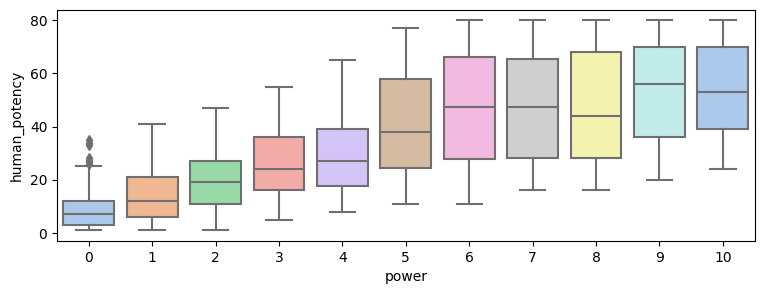

In [15]:
_ = sns.boxplot(data=df, x="power", y="human_potency", palette="pastel")

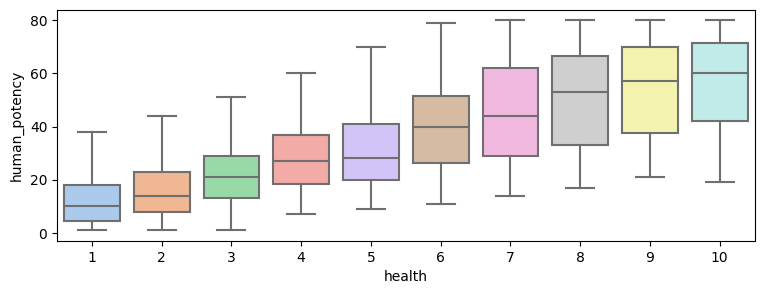

In [16]:
_ = sns.boxplot(data=df, x="health", y="human_potency", palette="pastel")

## Skills vs human potency

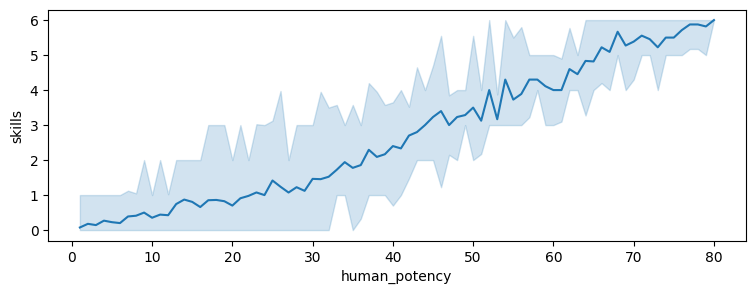

In [17]:
_ = sns.lineplot(data=df, x="human_potency", y="skills", errorbar=("pi", 95))

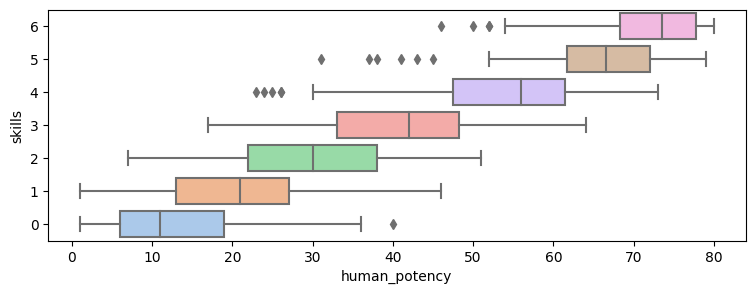

In [18]:
sns.boxplot(data=df, x="human_potency", y="skills", palette="pastel", orient="h")
_ = plt.gca().invert_yaxis()

## Histograms of individual skills

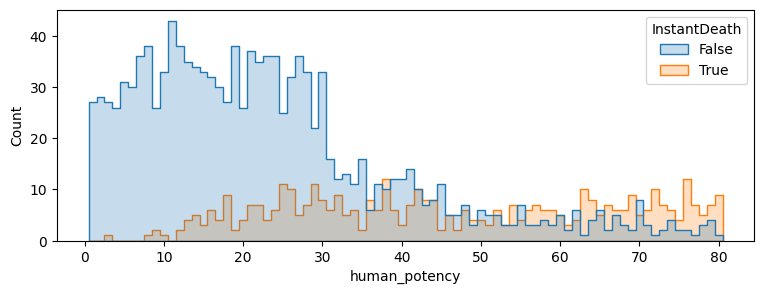

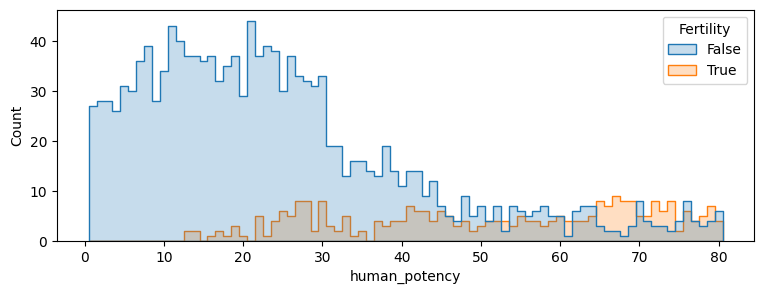

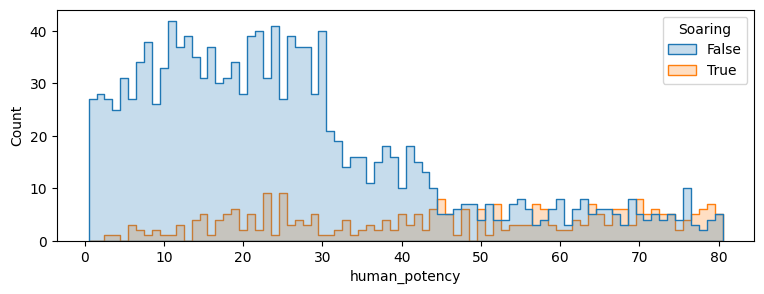

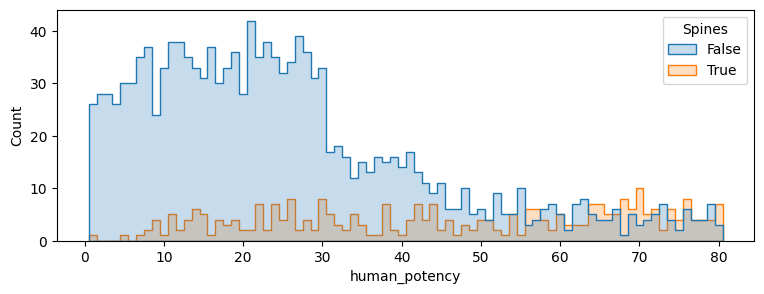

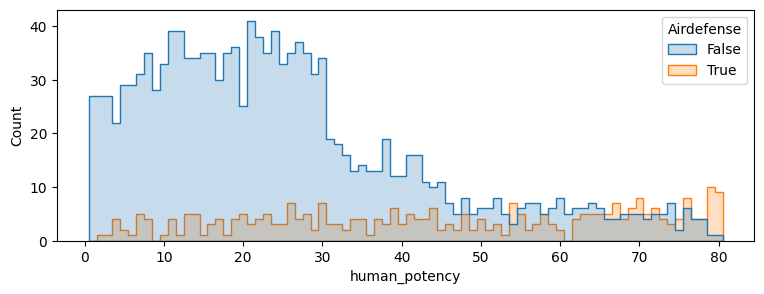

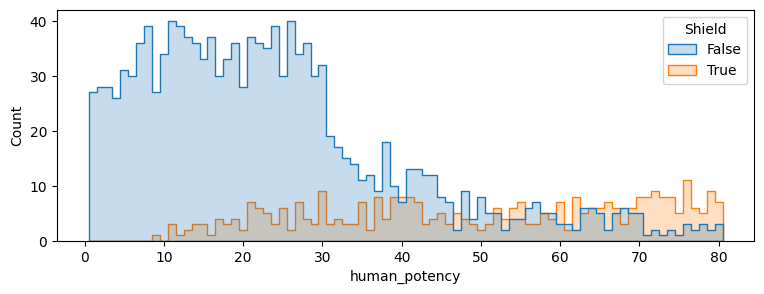

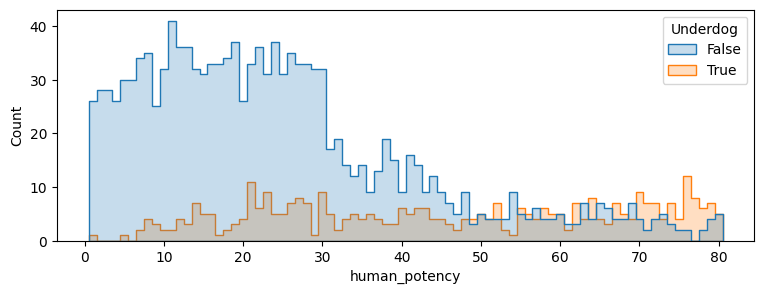

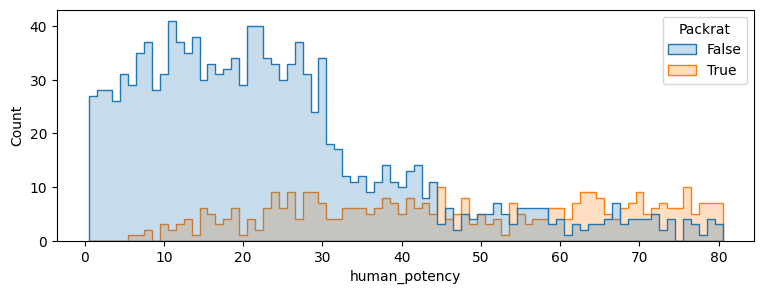

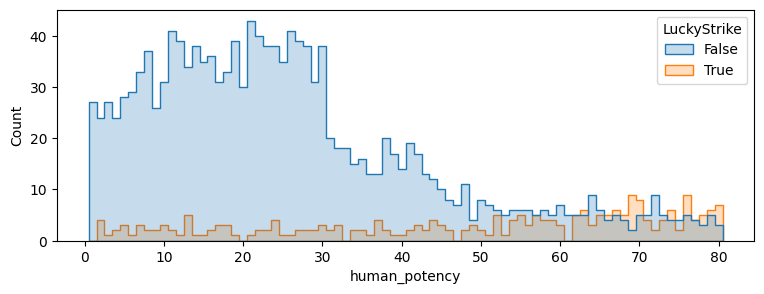

In [19]:
for s in  skill_names:
    sns.histplot(data=df, x="human_potency", discrete=True, hue=s, element="step")
    plt.show()
